In [106]:
# Cell 1 — Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.signal  import find_peaks


In [107]:
# Cell 2 — Load & merge on date index
PRED_CSV = "predicted_discharge.csv"      # ← adjust path if needed
OBS_CSV  = "sample_observed_data.csv"     # ← adjust path if needed

# 1) Load predictions
pred = pd.read_csv(PRED_CSV)
print("pred columns:", pred.columns.tolist())
# ensure your date column is datetime
pred['date'] = pd.to_datetime(pred['date'])
# rename your prediction column
pred = pred.rename(columns={'predicted_discharge': 'predicted'})

if "date" not in pred.columns:
    raise KeyError("Could not find your date column in the predictions – adjust the rename mapping above.")

# 2) Load observations
obs = pd.read_csv(OBS_CSV)
print("obs columns:", obs.columns.tolist())
obs['date'] = pd.to_datetime(obs['date'])
obs = obs.rename(columns={'QObs(mm/h)_obs': 'observed'})

if "date" not in obs.columns:
    raise KeyError("Could not find your date column in the observations – adjust the rename mapping above.")


# 3) Merge on date
df = pd.merge(
    obs[['date','observed']],
    pred[['date','predicted']],
    on='date',
    how='inner'
)

# 4) Drop NaNs
df = df.dropna(subset=['observed','predicted']).reset_index(drop=True)

# 5) Extract arrays for metrics and plots
dates  = df['date']
y_true = df['observed'].values
y_pred = df['predicted'].values

print(f"Final merged shape: {df.shape}")


pred columns: ['date', 'time_step', 'predicted_discharge', 'basin']
obs columns: ['date', 'time_step', 'QObs(mm/h)_obs']
Final merged shape: (794568, 3)


In [ ]:
# Cell 3 — Compute metrics
def compute_kge(obs: np.ndarray, sim: np.ndarray) -> float:
    r, _     = pearsonr(obs, sim)
    alpha    = np.std(sim, ddof=1) / np.std(obs, ddof=1)
    beta     = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def compute_peak_timing(obs: np.ndarray, sim: np.ndarray, window: int = 3) -> float:
    peaks_obs, _ = find_peaks(obs)
    if len(peaks_obs) == 0:
        return np.nan
    errors = []
    for i in peaks_obs:
        lo = max(0, i - window)
        hi = min(len(sim) - 1, i + window)
        j  = lo + np.argmax(sim[lo:hi+1])
        errors.append(abs(j - i))
    return float(np.mean(errors))

# now compute all metrics
mae         = mean_absolute_error(y_true, y_pred)
rmse        = np.sqrt(mean_squared_error(y_true, y_pred))
r2          = r2_score(y_true, y_pred)
kge         = compute_kge(y_true, y_pred)
nse         = 1 - np.sum((y_pred - y_true)**2) / np.sum((y_true - np.mean(y_true))**2)
pbias       = 100 * np.sum(y_pred - y_true) / np.sum(y_true)
peak_timing = compute_peak_timing(y_true, y_pred, window=3)

print(f"MAE:           {mae:.3f}")
print(f"RMSE:          {rmse:.3f}")
print(f"R²:            {r2:.3f}")
print(f"KGE:           {kge:.3f}")
print(f"NSE:           {nse:.3f}")
print(f"PBIAS (%):     {pbias:.3f}")
print(f"Peak-Timing:   {peak_timing:.3f}")


MAE:           0.030
RMSE:          0.054
R²:            0.760
KGE:           0.814
NSE:           0.760
PBIAS (%):     4.702
Peak-Timing:   1.943


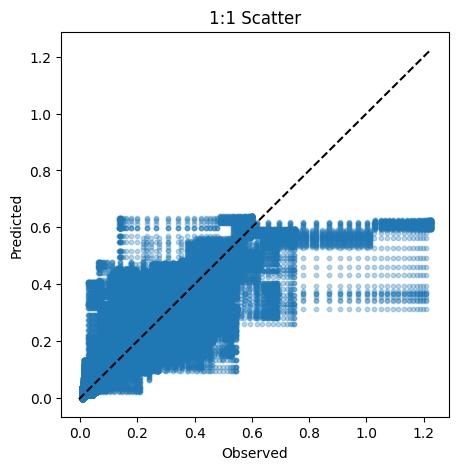

In [109]:
# Cell 4 — Scatter plot (1:1)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_true, y_pred, s=10, alpha=0.3)
_min = min(y_true.min(), y_pred.min())
_max = max(y_true.max(), y_pred.max())
ax.plot([_min,_max],[_min,_max],"k--")
ax.set_xlabel("Observed")
ax.set_ylabel("Predicted")
ax.set_title("1:1 Scatter")
plt.show()


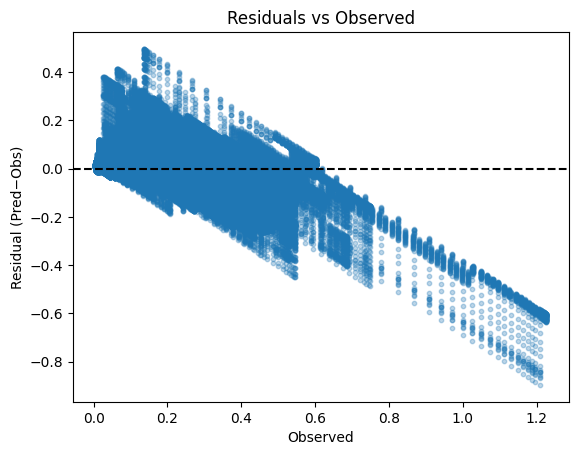

In [110]:
# Cell 5 — Residuals vs Observed
res = y_pred - y_true
fig, ax = plt.subplots()
ax.scatter(y_true, res, s=10, alpha=0.3)
ax.axhline(0, color="k", linestyle="--")
ax.set_xlabel("Observed")
ax.set_ylabel("Residual (Pred−Obs)")
ax.set_title("Residuals vs Observed")
plt.show()


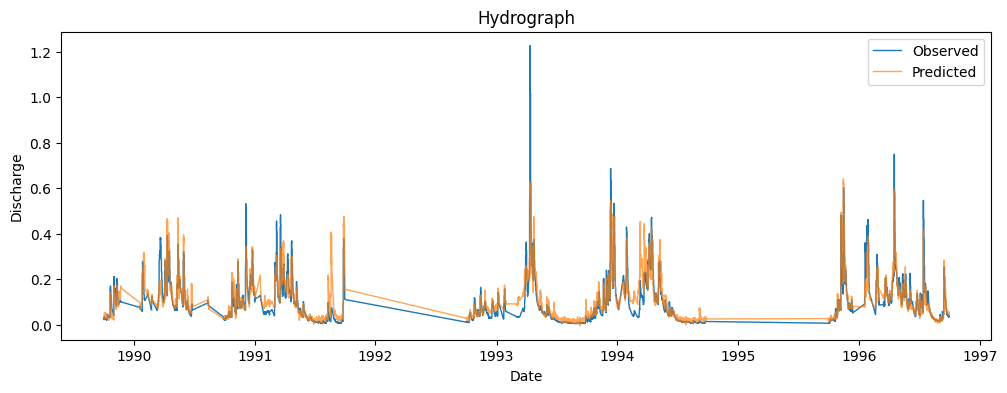

In [111]:
# Cell 6 — Hydrograph overlay (time series plot)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(dates, y_true,  label="Observed", lw=1)
ax.plot(dates, y_pred,  label="Predicted", lw=1, alpha=0.7)
ax.set_xlabel("Date")
ax.set_ylabel("Discharge")
ax.set_title("Hydrograph")
ax.legend()
plt.show()


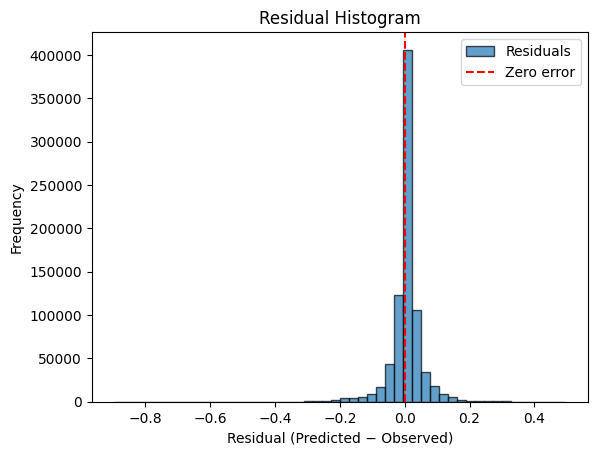

In [112]:
# Cell 7 — Error distribution
fig, ax = plt.subplots()
ax.hist(res, bins=50, alpha=0.7, edgecolor='black', label='Residuals')
ax.axvline(0,
           color='red',
           linestyle='--',
           label='Zero error')
ax.set_xlabel("Residual (Predicted − Observed)")
ax.set_ylabel("Frequency")
ax.set_title("Residual Histogram")
ax.legend()
plt.show()


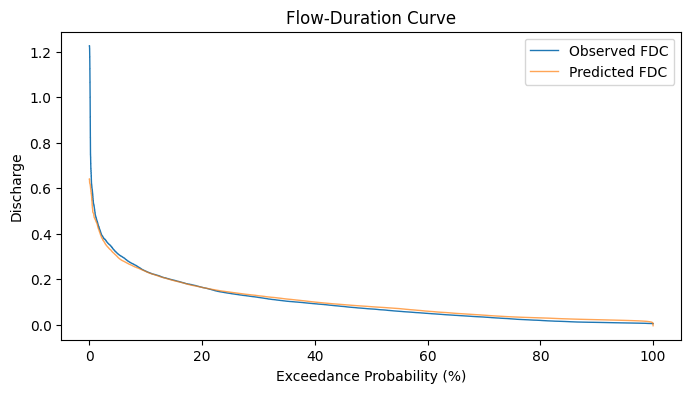

In [113]:
# Cell 8 — Flow‐Duration Curve
# 1) Sort descending
obs_sorted  = np.sort(y_true)[::-1]
pred_sorted = np.sort(y_pred)[::-1]

# 2) Compute exceedance probability (percent)
n = len(obs_sorted)
exceedance = np.arange(1, n+1) / n * 100

# 3) Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(exceedance, obs_sorted,  label="Observed FDC", lw=1)
ax.plot(exceedance, pred_sorted, label="Predicted FDC", lw=1, alpha=0.7)

ax.set_xlabel("Exceedance Probability (%)")
ax.set_ylabel("Discharge")
ax.set_title("Flow‐Duration Curve")
ax.legend()
plt.show()


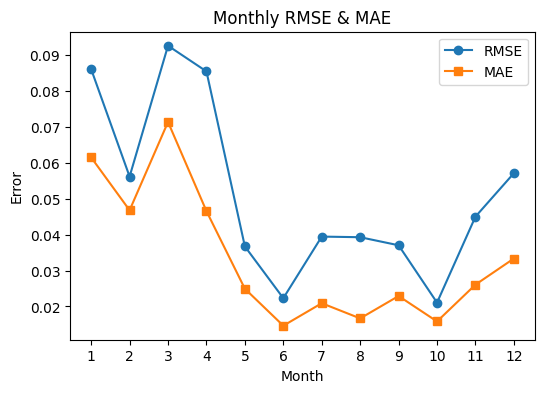

In [114]:
# Cell 9 — Seasonal RMSE & MAE by month

# 1) Ensure 'date' is datetime and extract month
df['date']  = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

# 2) Compute RMSE per month
monthly_rmse = (
    df.groupby('month')[['predicted','observed']]
      .apply(lambda g: np.sqrt(((g['predicted'] - g['observed'])**2).mean()))
      .sort_index()
)

# 3) Compute MAE per month
monthly_mae = (
    df.groupby('month')[['predicted','observed']]
      .apply(lambda g: np.abs(g['predicted'] - g['observed']).mean())
      .sort_index()
)

# 4) Plot both on the same figure
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(monthly_rmse.index, monthly_rmse.values, marker='o', label='RMSE')
ax.plot(monthly_mae.index, monthly_mae.values, marker='s', label='MAE')
ax.set_xticks(range(1,13))
ax.set_xlabel("Month")
ax.set_ylabel("Error")
ax.set_title("Monthly RMSE & MAE")
ax.legend()
plt.show()


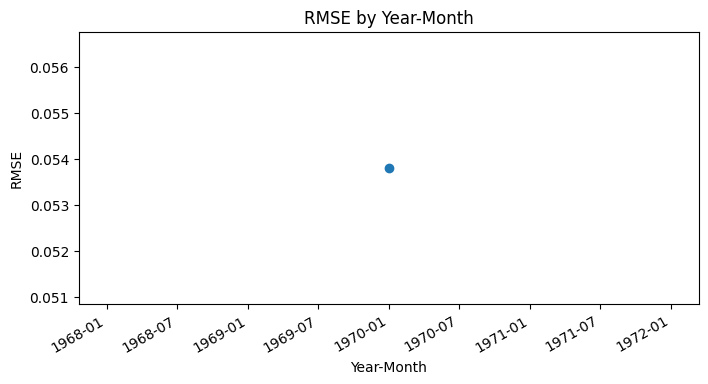

In [115]:
# Cell 9 — Year‐Month RMSE
# 1) Make sure your index is datetime
df.index = pd.to_datetime(df.index)

# 2) Group by year‐month period
#    This creates a PeriodIndex like '2024-04', '2024-05', '2025-04', etc.
monthly_rmse = (
    df
    .groupby(df.index.to_period("M"))[["predicted","observed"]]
    .apply(lambda g: np.sqrt(((g.predicted - g.observed)**2).mean()))
    .sort_index()
)

# 3) Convert the PeriodIndex back to timestamps for plotting
monthly_rmse.index = monthly_rmse.index.to_timestamp()

# 4) Plot
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(monthly_rmse.index, monthly_rmse.values, marker="o")
ax.set_xlabel("Year-Month")
ax.set_ylabel("RMSE")
ax.set_title("RMSE by Year-Month")
# auto‐format the x‐axis nicely
fig.autofmt_xdate()
plt.show()
